This is the final file submitted for the competition. I might have omitted some code for the sake of simpicity and readability.

In [1]:
#importing required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import xgboost
from xgboost import XGBRegressor

In [2]:
#importing train and test data
data=pd.read_csv("\\black_friday_train.csv",header=0)
test_data=pd.read_csv("\\black_friday_test.csv",header=0)

In [3]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
#Checking percentage of null values for each column
na_percent=data.isnull().sum()/data.isnull().count()*100
na_percent

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64

In [7]:
data.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

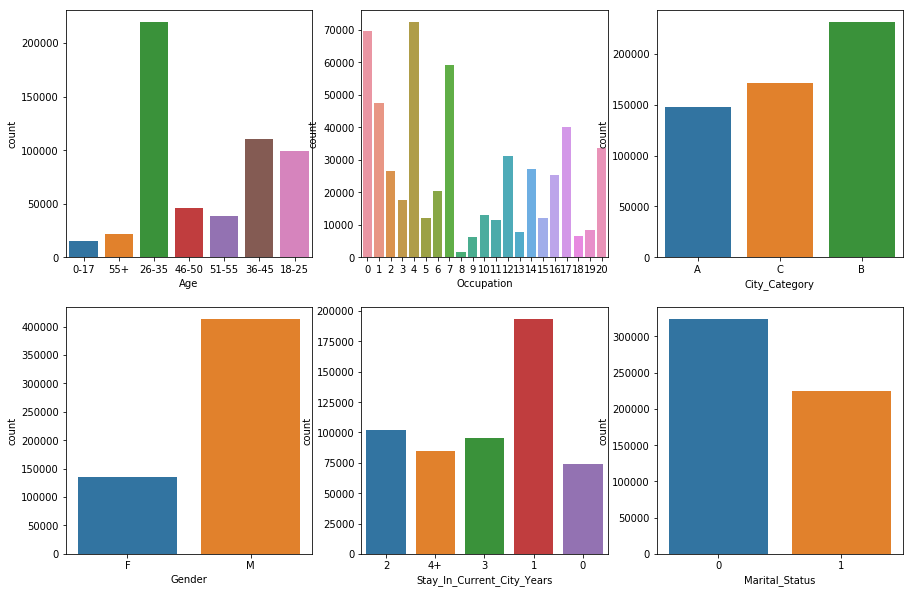

In [8]:
#ploltting categorical variables
fig,ax=plt.subplots(nrows=2,ncols=3,squeeze=False,figsize=(15,10))
sns.countplot(data=data,x='Age',ax=ax[0][0])
sns.countplot(data=data,x='Occupation',ax=ax[0][1])
sns.countplot(data=data,x='City_Category',ax=ax[0][2])
sns.countplot(data=data,x='Gender',ax=ax[1][0])
sns.countplot(data=data,x='Stay_In_Current_City_Years',ax=ax[1][1])
sns.countplot(data=data,x='Marital_Status',ax=ax[1][2])
plt.show()

In [9]:
#concatinate train and test data
data['train_data']=1
test_data['train_data']=0
full_data=pd.concat((data,test_data),axis=0,ignore_index=True)
full_data.head()

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Purchase,Stay_In_Current_City_Years,User_ID,train_data
0,0-17,A,F,0,10,3,NaN,NaN,P00069042,8370.0,2,1000001,1
1,0-17,A,F,0,10,1,6.0,14.0,P00248942,15200.0,2,1000001,1
2,0-17,A,F,0,10,12,NaN,NaN,P00087842,1422.0,2,1000001,1
3,0-17,A,F,0,10,12,14.0,NaN,P00085442,1057.0,2,1000001,1
4,55+,C,M,0,16,8,NaN,NaN,P00285442,7969.0,4+,1000002,1


In [10]:
#rearranging columns as per training data
full_data=full_data[data.columns]

In [11]:
#replacing NA values with 0 (Not replacing NA values with mean or anything else 
#because NA values in any of the Product category could simply mean the customer didnt buy an item from that category)
full_data.fillna(value=0,inplace=True)

In [12]:
full_data['Gender']=full_data['Gender'].map({'F':0,'M':1})
full_data['Stay_In_Current_City_Years']=full_data['Stay_In_Current_City_Years'].map({'0':0,'1':1,'2':2,'3':3,'4+':4})

In [13]:
full_data.Age.value_counts()

26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: Age, dtype: int64

In [14]:
'''Used this function for Age column
def med_mn(m,n):
    arr=np.arange(m,n+1)
    return np.median(arr) 
For 0-17, median is considered from 13-17 (assuming teenagers) and for 55+, considered from 55-65.'''
full_data['Age'] = full_data['Age'].map({'0-17': 15.5,
                               '18-25': 21.5,
                               '26-35': 30.5,
                               '36-45': 40.5,
                               '46-50': 48,
                               '51-55': 53,
                               '55+': 60})

In [15]:
#One hot encoding for City_Category column
full_data=pd.get_dummies(data=full_data,columns=['City_Category'])

In [16]:
full_data['ID']=full_data.User_ID-1000000
full_data['Product']=full_data.Product_ID.str.replace('P00','')

In [17]:
full_data=full_data.astype({'Product':'float64'},copy=True)

In [18]:
#separating training and testing data
train_data=full_data[full_data['train_data']==1]
test_data1=full_data[full_data['train_data']==0]

In [19]:
train_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,train_data,City_Category_A,City_Category_B,City_Category_C,ID,Product
0,1000001,P00069042,0,15.5,10,2,0,3,0.0,0.0,8370.0,1,1,0,0,1,69042.0
1,1000001,P00248942,0,15.5,10,2,0,1,6.0,14.0,15200.0,1,1,0,0,1,248942.0
2,1000001,P00087842,0,15.5,10,2,0,12,0.0,0.0,1422.0,1,1,0,0,1,87842.0
3,1000001,P00085442,0,15.5,10,2,0,12,14.0,0.0,1057.0,1,1,0,0,1,85442.0
4,1000002,P00285442,1,60.0,16,4,0,8,0.0,0.0,7969.0,1,0,0,1,2,285442.0


In [25]:
#To check if traing data consists of all test data IDs and vice-versa. (Length is same whole train or test data) 
ser1=train_data['User_ID'].sort_values()
ser2=test_data1['User_ID'].sort_values()
print('{}, {}'.format(len(ser1[ser1.isin(ser2)]),len(ser2[ser2.isin(ser1)])))

550068, 233599


In [26]:
#Since all training data IDs are in test data, we can label them using LabelEncoder()
le=LabelEncoder()
train_data['ID']=le.fit_transform(train_data['ID'])
test_data1['ID']=le.transform(test_data1['ID'])

In [27]:
# Since product IDs have different values in test and train data (can check same way as above)
scaler=MinMaxScaler()
df_train=train_data.copy() #So that original data is not affected
df_test=test_data1.copy()
for column in ['Age','Occupation','Stay_In_Current_City_Years','Product_Category_1','Product_Category_2',
               'Product_Category_3','Product']:
    df_train[column]=scaler.fit_transform(pd.DataFrame(df_train[column])) #Used pd.DataFrame to avoid using .reshape(-1,1)
    df_test[column]=scaler.transform(pd.DataFrame(df_test[column]))

In [28]:
#Drop columns not to be used for training the model
df_train.drop(columns=['User_ID','Product_ID','train_data'],inplace=True)
df_test.drop(columns=['User_ID','Product_ID','Purchase','train_data'],inplace=True)

In [29]:
df_train.head()

,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_A,City_Category_B,City_Category_C,ID,Product
0,0,0.0,0.5,0.5,0,0.105263,0.000000,0.000000,8370.0,1,0,0,0,0.183589
1,0,0.0,0.5,0.5,0,0.000000,0.333333,0.777778,15200.0,1,0,0,0,0.662947
2,0,0.0,0.5,0.5,0,0.578947,0.000000,0.000000,1422.0,1,0,0,0,0.233683
3,0,0.0,0.5,0.5,0,0.578947,0.777778,0.000000,1057.0,1,0,0,0,0.227288
4,1,1.0,0.8,1.0,0,0.368421,0.000000,0.000000,7969.0,0,0,1,1,0.760204


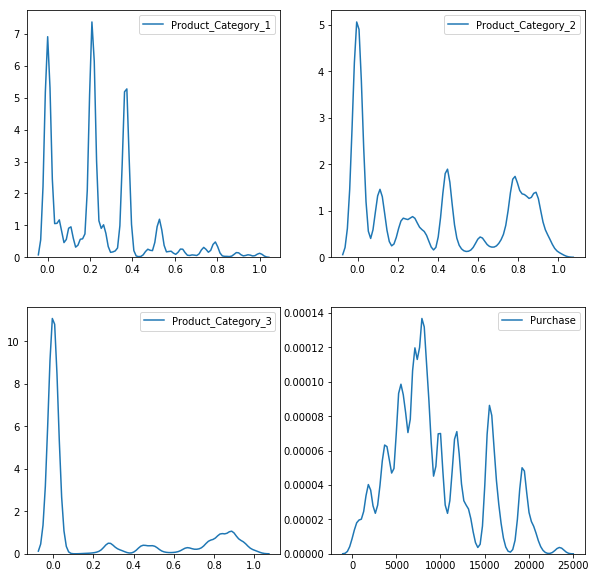

In [30]:
#Check distribution of continuous variables
fig,ax=plt.subplots(2,2,squeeze=False,sharex=False,figsize=(10,10))
sns.kdeplot(data=df_train.Product_Category_1,ax=ax[0][0])
sns.kdeplot(data=df_train.Product_Category_2,ax=ax[0][1])
sns.kdeplot(data=df_train.Product_Category_3,ax=ax[1][0])
sns.kdeplot(data=df_train.Purchase,ax=ax[1][1])
plt.show()

In [31]:
#Correlation matrix
corr_matrix=df_train.corr(method='spearman')
corr_matrix[corr_matrix>np.abs(0.6)]

,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_A,City_Category_B,City_Category_C,ID,Product
Gender,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stay_In_Current_City_Years,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category_1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category_2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Purchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
City_Category_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


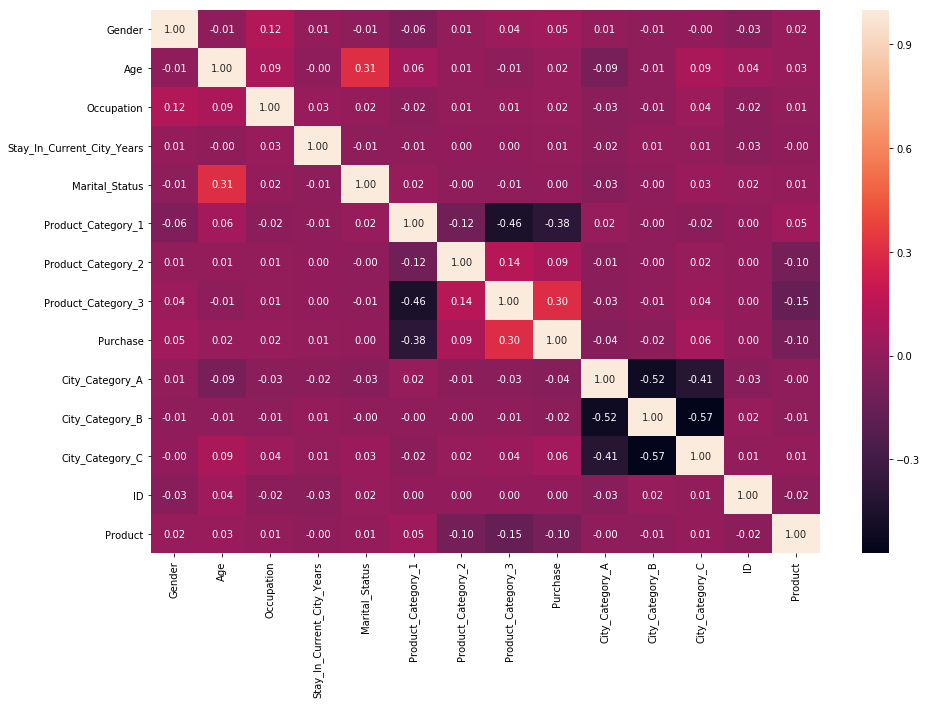

In [32]:
#There is no strong correlation except for city categories, which is expected. 
plt.figure(figsize=(15,10))
sns.heatmap(data=corr_matrix,annot=True,fmt='.2f')
plt.show()

In [33]:
#Splitting the training data into train and validate sets.
r_s=100
X=df_train.drop(['Purchase'],axis=1)
Y=df_train['Purchase']
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,train_size=0.8,random_state=r_s,shuffle=True)

In [34]:
#Getting a baseline idea for the error
model=LinearRegression()
kfold=KFold(n_splits=5,random_state=r_s)
score=cross_val_score(model,X_train,Y_train,scoring='neg_root_mean_squared_error')
print('RMSE: ',-np.mean(score))

RMSE:  4616.733105726877


#Compared all models and plotted their boxplots in similar manner, XGBRegressor() and RandomForestRegressor() gave
least validation error. But XGBRegressor is faster to train.
 
LinearRegression: 4616.733105,
KNeighborsRegressor: 4582.717427,
DecisionTreeRegressor: 3768.693010,
RandomForestRegressor: 2632.164310,
AdaBoostRegressor: 2876.689096,
GradientBoostingRegressor: 3249.498231,
LGBMRegressor: 2771.135486,
XGBRegressor: 2635.571683

In [37]:
model_xgb=XGBRegressor()
model_xgb.fit(X_train,Y_train)
Y_pred=model_xgb.predict(X_val)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(Y_val,Y_pred))))

RMSE: 2635.576183038545


In [38]:
#Fine tuned XGBRegressor using RandomizedSearchCV and trained three such models.
model1=XGBRegressor(n_estimators=400,max_depth=7,min_child_weight=20,learning_rate=0.2,
                    subsample=0.9,colsample_bytree=0.8,gamma=1)
model2=XGBRegressor(n_estimators=300,max_depth=8,min_child_weight=30)
model3=XGBRegressor(n_estimators=500,max_depth=10,min_child_weight=40)

In [39]:
#Final model trained using full training data
for model in [model1,model2,model3]:
    model.fit(X,Y)

In [40]:
#Taking weighted average of all 3 models to reduce error and overfitting
pred1=model1.predict(df_test)
pred2=model2.predict(df_test)
pred3=model3.predict(df_test)
final_prediction=(0.2*pred1+0.5*pred2+0.3*pred3)

In [41]:
#Prepare the submission file of the predictions.
submission=pd.DataFrame(data=test_data1[['User_ID','Product_ID']])
submission['Purchase']=final_prediction
submission.to_csv('Submission.csv',index=False)

My Test Score was 2481.93496. This can be improved with some more feature engg and using deep learning methods. 
That was the approach followed by 1st poition holder with RMSE score of 2380. 
But, won't go into that as i'm just presenting my solution for the probem.